### В данном мини-проекте проведем эксперимент с сравнием групп двумя способами: бутстрапом и u-тестом.
Сравним результат между тестом и контролем по двум кейсам:
  + Применим бутстрап (с np.mean) и критерий mann-whitney, а потом сравним p-value
  + Применим бутстрап (с np.median) и критерий mann-whitney, а потом сравним p-value.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\yarus\projects\data\hw_bootstrap.csv", sep=';')

In [3]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
df.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

### Описание колонок: 
value – значения метрики \
experimentVariant – вариант теста (Control – контроль, Treatment – тест)

Удалим ненужный столбец.

In [5]:
df = df.drop(columns=df.columns[0])

In [6]:
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [7]:
df.dtypes

value                object
experimentVariant    object
dtype: object

Приведем значение метрики к обрабатываемому виду.

In [8]:
df['value'] = df['value'].str.replace(',', '.').astype('float')

In [9]:
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [10]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [11]:
df_control = df.query('experimentVariant == "Control"').reset_index(drop=True)['value']

In [12]:
df_control.head()

0    10.380495
1     9.546867
2    11.088215
3    10.147274
4     9.789808
Name: value, dtype: float64

Посмотрим на распределение метрики в контрольной группе.

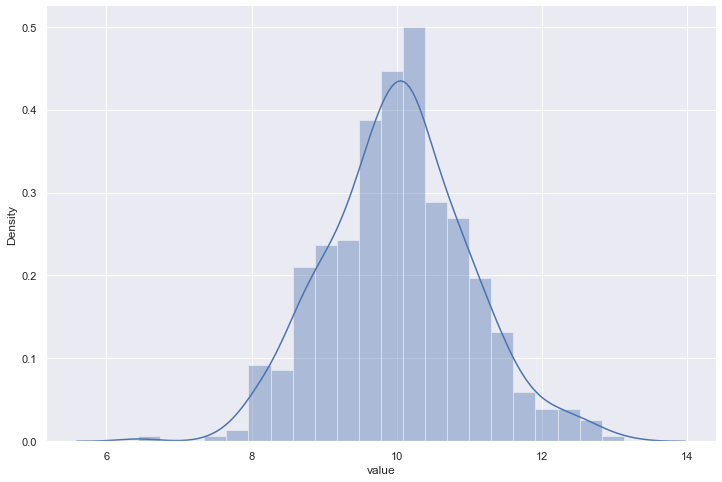

In [13]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.distplot(df_control)
sns.despine()

Распределение признака в контрольной группе - нормальное.

In [14]:
df_test = df.query('experimentVariant == "Treatment"').reset_index(drop=True)['value']

In [15]:
df_test.head()

0    10.380495
1     9.546867
2    11.088215
3    10.147274
4     9.789808
Name: value, dtype: float64

Посмотрим на распределение метрики в тестовой группе.

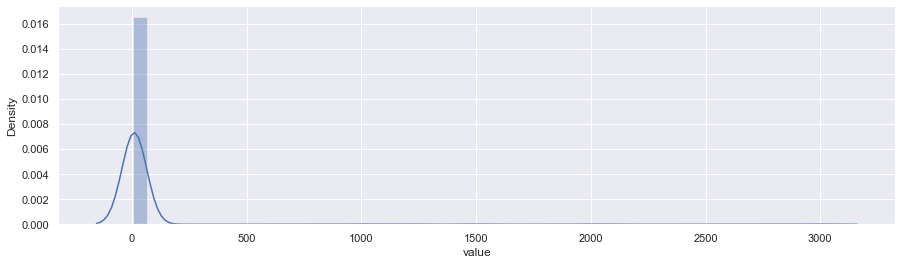

In [16]:
sns.set(rc = {'figure.figsize':(15,4)})
sns.distplot(df_test)
sns.despine()

Распределение признака в тестовой группе не является нормальным, заметны выбросы.

Создадим функцию для проверки гипотез с помощью метода bootstrap.

In [17]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # применяем статистику
    
    #приведем все в один датафрейм    
    pd_boot_data = pd.DataFrame(boot_data)
        
    #найдем значения доверительного интервала, относительно нашего уровня значимости
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50, color='blue')
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,colors='black', linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
      
    return {"boot_data": boot_data, 
            "quants": ci, 
            "p_value": p_value}

### Сравним средние значения в тестовой и контрольной группах с помощью бутстрапа
* Нулевая гипотеза H0: Средние значения в двух группах не различаются
* Альтернативная гипотеза H1: Средние значения различаются

  0%|          | 0/1000 [00:00<?, ?it/s]

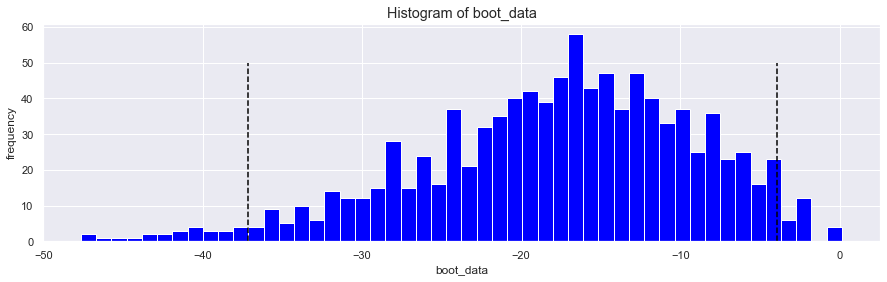

In [18]:
booted_data_mean = get_bootstrap(df_control, df_test, boot_it = 1000, statistic = np.mean) 
# в результате хранится разница двух распределений, ДИ и p-value

Посмотрим на значения p-value и ДИ. 

In [19]:
booted_data_mean["p_value"].round(4)

0.0397

In [20]:
booted_data_mean["quants"].round(3)

,0
0.025,-37.151
0.975,-3.953


### Вывод по бутстрапу (средние значения):
Средние значения в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

`p-value < 0.05` говорит о том, что при условии верности нулевой гипотезы о равенстве средних в двух группах вероятность получить такое или еще большее отклонение разницы от 0 составляет менее 5 %. Значит, мы имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

### Сравниваем медианы в тестовой и контрольной группах с помощью бутстрапа
* Нулевая гипотеза H0: Медианы в двух группах не различаются
* Альтернативная гипотеза H1: Медианы различаются

  0%|          | 0/1000 [00:00<?, ?it/s]

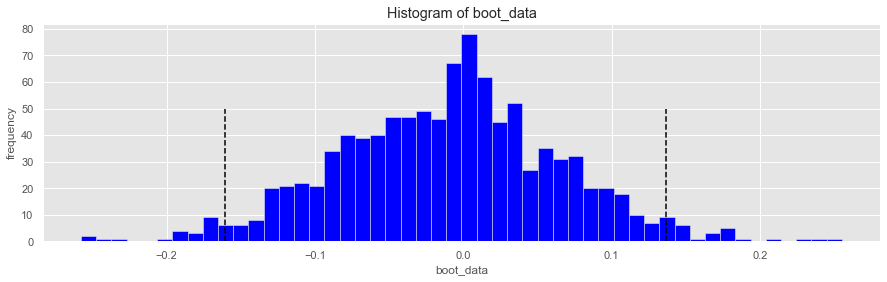

In [21]:
booted_data_median = get_bootstrap(df_control, df_test, boot_it = 1000, statistic = np.median)
# в результате хранится разница двух распределений, ДИ и p-value

Посмотрим на значения p-value и ДИ.

In [22]:
booted_data_median["p_value"].round(4)

0.8899

In [23]:
booted_data_median["quants"].round(3)

,0
0.025,-0.160
0.975,0.137


### Вывод по бутстрапу (медианы):
Медианы в тестовой и контрольной группах не различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал попадает нулевое значение разницы между медианами двух групп.

`p-value > 0.05` говорит о том, что при условии верности нулевой гипотезы о равенстве медиан в двух группах вероятность получить такое или еще большее отклонение разницы от 0 составляет более 5 %. То есть полученная нами разница не оказалась бы редким явлением, если бы медианы двух групп на самом деле были равны. Значит, мы не имеем весомых оснований отвергнуть нулевую гипотезу и остаемся в ее рамках.

### Сравниваем тестовую и контрольную группы с помощью U-критерия Манна-Уитни
* Нулевая гипотеза H0: Группы не различаются
* Альтернативная гипотеза H1: Группы различаются

In [24]:
mannwhitneyu(df_control, df_test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

### Вывод по U-критерию Манна-Уитни:
Значение `p-value > 0.05` говорит об отсутствии статистически значимых различий между контрольной и тестовой группами. Мы не имеем оснований отвергнуть нулевую гипотезу, то есть группы не отличаются.

## Сравнение результатов и общие выводы

In [25]:
df_diff = df_control - df_test

In [26]:
df_diff

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
          ...     
495    -989.026071
496   -1189.738926
497   -1491.219910
498   -1988.830922
499   -2988.500434
Name: value, Length: 500, dtype: float64

In [27]:
len(df_diff[df_diff != 0])

5

Можно заметить, что контрольная и тестовая группы имеют разные значения только у последних 5 наблюдений.

In [28]:
df_control.mean()

10.0268665338043

In [29]:
df_test.mean()

27.321499056661583

Последние 5 наблюдений в тестовой группе - это экстремально высокие значения, которые смещают среднее тестовой группы в большую сторону.
Это объясняет, почему бутстрап для средних значений показал статистически значимое различие `(p < 0.05)` между средними двух групп.

В то же время медианы двух групп практически идентичны, так как медиана гораздо менее чувствительна к выбросам, чем среднее:

In [30]:
df_control.median()

10.0184651909296

In [31]:
df_test.median()

10.02584684253515

Соответственно, бутстрап для медиан показал отсутствие статистически значимого различия (p > 0.05) между медианами двух групп.

Непараметрический U-критерий Манна-Уитни также менее чувствителен к выбросам, поскольку использует ранговую шкалу для оценки различий между двумя группами. Данный критерий также показал, что между группами нет статистически значимых различий.

В рассмотренном случае стоит доверять бутстрапу для медиан и U-критерию Манна-Уитни, поскольку они менее чувствительны к экстремально большим (или малым) значениям.